# Knowledge captured by COLOMBOS and Ecomics

Based on an approach suggested by Ecomics authors, the following analysis wants to evaluate dataset quality looking for known genes associated with specific stresses starting from fold-changes.

The second stress used is **oxygen supply**. Known genes have been collected from RegulonDB (https://www.ncbi.nlm.nih.gov/pubmed/26527724).

  1. Find all conditions (i.e. unique combinations of strain, medium, stresses exposed, and genetic perturbations) exposed under the stress
  2. Find the corresponding wild-type conditions (i.e. all condition features of strain, medium, genetic perturbations are identical except for no stress exposed).
  3. Measure fold-changes of all genes for each pair (stress condition and its wild-type). 
  4. Rank genes by mean absolute fold-change.
  5. Compare how many known genes are more present in top genes between the two datasets.
  
In COLOMBOS there's no need to calculate fold-changes since values are already ratios.

In [1]:
import pandas as pd
import numpy as np

In [2]:
### Read COLOMBOS contrast data
colombos_ctr_data = pd.read_table('colombos_ecoli_exprdata_20151029.txt', sep='\t', nrows=6)
colombos_ctr_data = colombos_ctr_data[colombos_ctr_data.columns[2:]]
colombos_ctr_data = colombos_ctr_data.set_index(colombos_ctr_data.columns[0])
colombos_ctr_data.index = list(colombos_ctr_data.index[:-1]) + ['Contrast ID']

### Read COLOMBOS gene data
colombos_gene_data = pd.read_table('colombos_ecoli_exprdata_20151029.txt', sep='\t', skiprows=6)
colombos_gene_data = colombos_gene_data[colombos_gene_data.columns[:3]]
colombos_gene_data.columns = list(colombos_gene_data.columns[:2]) + ['Gene ID']
colombos_gene_data = colombos_gene_data.set_index('Gene ID')
colombos_gene_data['LocusTag'] = ['m.' + lc for lc in colombos_gene_data['LocusTag'].tolist()]

### Read COLOMBOS expression data
colombos_exp_data = pd.read_table('colombos_ecoli_exprdata_20151029.txt', sep='\t', skiprows=6)
colombos_exp_data = colombos_exp_data[colombos_exp_data.columns[2:]]
colombos_exp_data = colombos_exp_data.rename(columns = {'Geneid/Contrast_id':'Gene ID'})
colombos_exp_data = colombos_exp_data.set_index('Gene ID')

### Read COLOMBOS test sample annotation data
colombos_test_annot = pd.read_table('colombos_ecoli_testannot_20151029.txt', sep='\t')
ctr_name = colombos_test_annot['ContrastName'].tolist()
colombos_test_annot = pd.DataFrame(colombos_test_annot['TestAnnotation'].str.split(':').tolist(), 
             columns= ['TestAnnot', 'Value', 'None'])
del colombos_test_annot['None']
colombos_test_annot.insert(0, 'ContrastName', ctr_name)
colombos_test_annot = colombos_test_annot.set_index('ContrastName')

### Read COLOMBOS reference sample annotation data
colombos_ref_annot = pd.read_table('colombos_ecoli_refannot_20151029.txt', sep='\t')
ctr_name = colombos_ref_annot['ContrastName'].tolist()
colombos_ref_annot = pd.DataFrame(colombos_ref_annot['RefAnnotation'].str.split(':').tolist(), 
             columns= ['RefAnnot', 'Value', 'None'])
del colombos_ref_annot['None']
colombos_ref_annot.insert(0, 'ContrastName', ctr_name)
colombos_ref_annot = colombos_ref_annot.set_index('ContrastName')

In [3]:
### Read Ecomics annotation data
ecomics_info = pd.read_csv('ncomms13090-s2_trans.csv', index_col=0)

In [4]:
### Read Ecomics expression data
ecomics_v8 = pd.read_csv('ecomics.transcriptome.no_avg.v8.txt', sep='\t', index_col=0)

In [5]:
oxygen_genes = ['m.b0118','m.b0311','m.b0314','m.b0564','m.b0568','m.b0621','m.b0733','m.b0781','m.b0894',
                'm.b0895','m.b0896','m.b0972','m.b0996','m.b0997','m.b0998','m.b1109','m.b1223','m.b1224',
                'm.b1225','m.b1226','m.b1227','m.b1241','m.b1276','m.b1324','m.b1415','m.b1611','m.b1612',
                'm.b2208','m.b2468','m.b2481','m.b2552','m.b2579','m.b2712','m.b2713','m.b2718','m.b2719',
                'm.b2720','m.b2721','m.b2722','m.b2723','m.b2724','m.b2725','m.b2731','m.b3365','m.b3575',
                'm.b3806','m.b3961','m.b4075','m.b4117','m.b4122','m.b4123','m.b4187','m.b4401']

### Ecomics oxygen genes

In [6]:
ea_idx = ecomics_v8.copy(deep=True)
ea_idx.insert(0, 'Strain', ecomics_info['Strain Name'])
ea_idx.insert(0, 'MediumID', ecomics_info['MD ID'])
ea_idx.insert(0, 'Medium', ecomics_info['Base Medium'])
ea_idx.insert(0, 'GP', ecomics_info['GP Type'])
ea_idx.insert(0, 'Stress', ecomics_info['Stress'])
del ea_idx['Cond']
ea_idx_oxygen = ea_idx[ea_idx['Stress'] == 'O2-starvation'].set_index(['Strain', 'MediumID', 'Medium', 'GP', 'Stress'])
ea_idx_oxygen = ea_idx_oxygen.groupby(level=['Stress', 'Strain', 'MediumID', 'Medium', 'GP'], axis=0).mean()
fc_oxygen = {}
for i,row in ea_idx_oxygen.iterrows():
    _df = ea_idx[(ea_idx['Stress'] == 'none')&(ea_idx['Strain'] == i[1])&(ea_idx['MediumID'] == i[2])&
                 (ea_idx['Medium'] == i[3])&(ea_idx['GP'] == i[4])].mean().to_frame()
    _df.insert(0, 'oxygen', row)
    _df.columns = ['oxygen', 'wt']
    fc_oxygen[i] = _df['oxygen'] / _df['wt']
fc_oxygen = pd.DataFrame(fc_oxygen)
fc_oxygen_ranked = list(fc_oxygen.mean(axis=1).sort_values(ascending=False).index)

x_oxygen = np.arange(0,2000,100)
y_oxygen_ecomics = [len(set(fc_oxygen_ranked[:k]).intersection(set(oxygen_genes))) / len(oxygen_genes) for k in x_oxygen]

### COLOMBOS oxygen genes

In [7]:
oxygen_ctrs_ref = colombos_ref_annot[colombos_ref_annot['RefAnnot'] == 'OXYGEN']['Value'].to_frame()
oxygen_ctrs_test = colombos_test_annot[colombos_test_annot['TestAnnot'] == 'OXYGEN']['Value'].to_frame()
oxygen_ctrs = pd.DataFrame(columns=['test', 'ref'], index=list(oxygen_ctrs_ref.index) + list(oxygen_ctrs_test.index))
oxygen_ctrs['test'] = oxygen_ctrs_test
oxygen_ctrs['ref'] = oxygen_ctrs_ref
oxygen_ctrs = oxygen_ctrs[(oxygen_ctrs['test'] != oxygen_ctrs['ref'])&(oxygen_ctrs['test'] != '-1-1')&
                          (oxygen_ctrs['test'] != '1+1')].index

colombos_oxygen_ranked = colombos_exp_data[colombos_ctr_data[oxygen_ctrs].loc['Contrast ID'].values].mean(axis=1).abs().sort_values(ascending=False).index
colombos_oxygen_ranked = colombos_gene_data.loc[colombos_oxygen_ranked]['LocusTag']
y_oxygen_colombos = [len(set(colombos_oxygen_ranked[:k]).intersection(set(oxygen_genes))) / len(oxygen_genes) for k in x_oxygen]

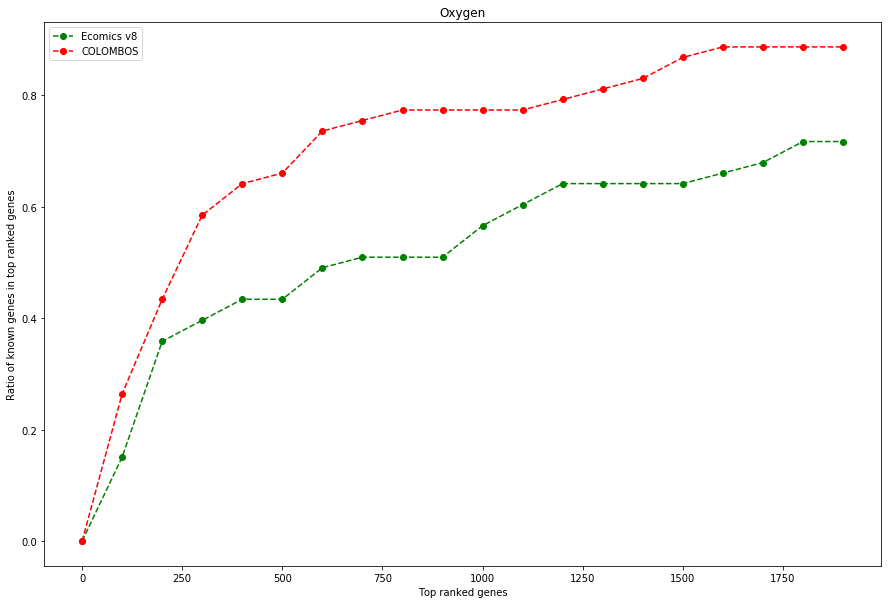

In [8]:
import seaborn as sea
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,10))

plt.plot(x_oxygen, y_oxygen_ecomics, linestyle='--', marker='o', color='g', label='Ecomics v8')
plt.plot(x_oxygen, y_oxygen_colombos, linestyle='--', marker='o', color='r', label='COLOMBOS')
plt.legend(loc='best')
plt.title('Oxygen')
plt.xlabel('Top ranked genes')
plt.ylabel('Ratio of known genes in top ranked genes')
plt.show()